In [1]:
import pandas as pd
import os
import scipy.io.wavfile as wavfile
from scipy.signal import spectrogram
import matplotlib.pyplot as plt
import numpy as np

In [3]:
metadata_file_path = 'projectiitg/bird_songs_metadata.csv'
metadata_df = pd.read_csv(metadata_file_path)

In [4]:
wav_files_dir = 'projectiitg/wavfiles'

In [5]:
example_files = metadata_df['filename'].unique()[:3]

In [6]:
def plot_spectrogram_scipy(file_path):
    sample_rate, samples = wavfile.read(file_path)
    f, t, Sxx = spectrogram(samples, sample_rate)
    
    plt.figure(figsize=(10, 4))
    plt.pcolormesh(t, f, 10 * np.log10(Sxx))
    plt.ylabel('Frequency [Hz]')
    plt.xlabel('Time [sec]')
    plt.title('Spectrogram')
    plt.colorbar(format='%+2.0f dB')
    plt.tight_layout()
    plt.show()


Plotting spectrogram for 557838-0.wav


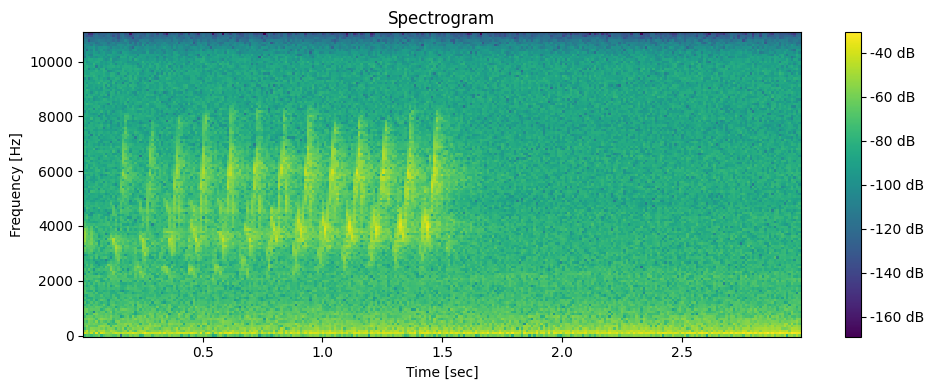

Plotting spectrogram for 557838-1.wav


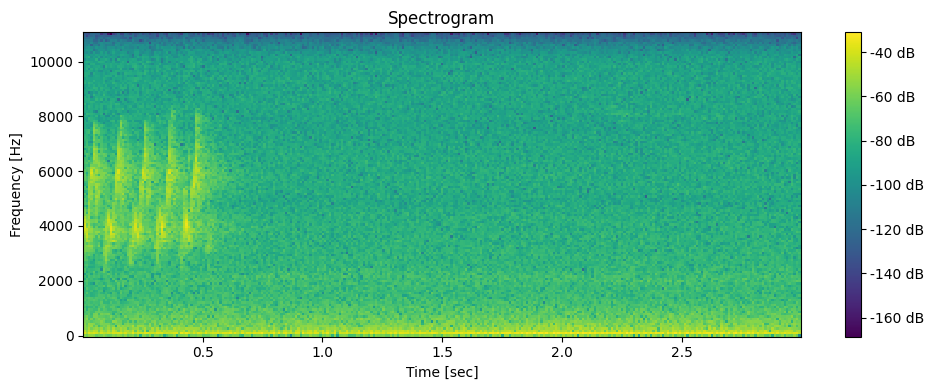

Plotting spectrogram for 557838-4.wav


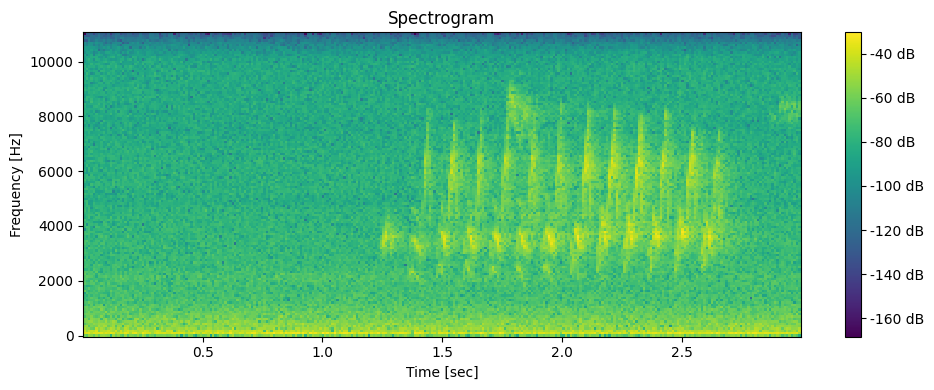

In [7]:
for file in example_files:
    file_path = os.path.join(wav_files_dir, file)
    print(f"Plotting spectrogram for {file}")
    plot_spectrogram_scipy(file_path)

## Preprocessing

In [8]:
import os
import pandas as pd
import numpy as np
import librosa
import librosa.display

In [9]:
n_mfcc = 13
sample_rate = 22050
duration = 3
n_fft = 2048
hop_length = 512

In [10]:
def extract_mfcc(file_path, sample_rate, duration, n_mfcc, n_fft, hop_length):
    y, sr = librosa.load(file_path, sr=sample_rate, duration=duration)
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc, n_fft=n_fft, hop_length=hop_length)
    return mfccs

In [11]:
features = []
labels = []

In [12]:
from tqdm import tqdm

In [13]:
for index, row in tqdm(metadata_df.iterrows(), total=metadata_df.shape[0]):
    file_path = os.path.join(wav_files_dir, row['filename'])
    mfccs = extract_mfcc(file_path, sample_rate, duration, n_mfcc, n_fft, hop_length)
    features.append(mfccs)
    labels.append(row['name'])

100%|██████████████████████████████████████████████████████████████████████████████| 5422/5422 [00:58<00:00, 92.30it/s]


In [14]:
features = np.array(features)
labels = np.array(labels)

In [15]:
np.save('features.npy', features)
np.save('labels.npy', labels)

In [16]:
def extract_features(file_path, sample_rate, duration, n_mfcc, n_fft, hop_length):
    y, sr = librosa.load(file_path, sr=sample_rate, duration=duration)
    
    
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc, n_fft=n_fft, hop_length=hop_length)
    
 
    chroma = librosa.feature.chroma_stft(y=y, sr=sr, n_fft=n_fft, hop_length=hop_length)
    

    S = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=n_fft, hop_length=hop_length)
    S_dB = librosa.power_to_db(S, ref=np.max)
    
    return mfccs, chroma, S_dB

In [17]:
features = []
labels = []

In [1]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout
from tensorflow.keras.optimizers import Adam

In [ ]:
features = np.load('features.npy')
labels = np.load('labels.npy')

In [ ]:
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels)
labels_categorical = to_categorical(labels_encoded)

In [ ]:
features = features[..., np.newaxis]

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(features, labels_categorical, test_size=0.2, random_state=42)

In [ ]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(features.shape[1], features.shape[2], features.shape[3])),
    MaxPooling2D((2, 2)),
    Dropout(0.25),
    
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.25),
    
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(len(label_encoder.classes_), activation='softmax')
])

In [ ]:
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test))


In [ ]:
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test accuracy: {test_accuracy:.2f}")

In [ ]:
import tensorflow as tf
tf.__version__

In [ ]:
!python --version

In [ ]:
!conda info --envs